In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math
import pickle
from detect_peaks import detect_peaks
import ruptures as rpt
from numpy.random import seed
seed(60)
from tensorflow import set_random_seed
set_random_seed(60)
#random.seed(42) # f1 30
#random.seed(4300) # f1 0.29
#random.seed(6) # f1 0.29
#random.seed(8) # f1 0.28
#random.seed(50) #f1 0.31
#random.seed(60) #f1 0.34
#random.seed(80) #f1 0.3
#random.seed(0.65) #f1 0.31


import keras
from os import listdir, walk
from os.path import isfile, join
from detect_peaks import detect_peaks
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import ruptures as rpt
import tensorflow as tf
from keras import layers, models
from keras.layers import LSTM, GRU, Dropout, Dense, Input, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras import optimizers 
from keras import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

In [3]:
path = '../../DDC_Data/wisdm/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

In [4]:
data = pd.read_csv(path, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

In [5]:
data

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926
7,33,Jogging,49106652389000,-0.503953,13.947236,7.0553403
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871
9,33,Jogging,49106872299000,0.953424,1.375655,1.6480621


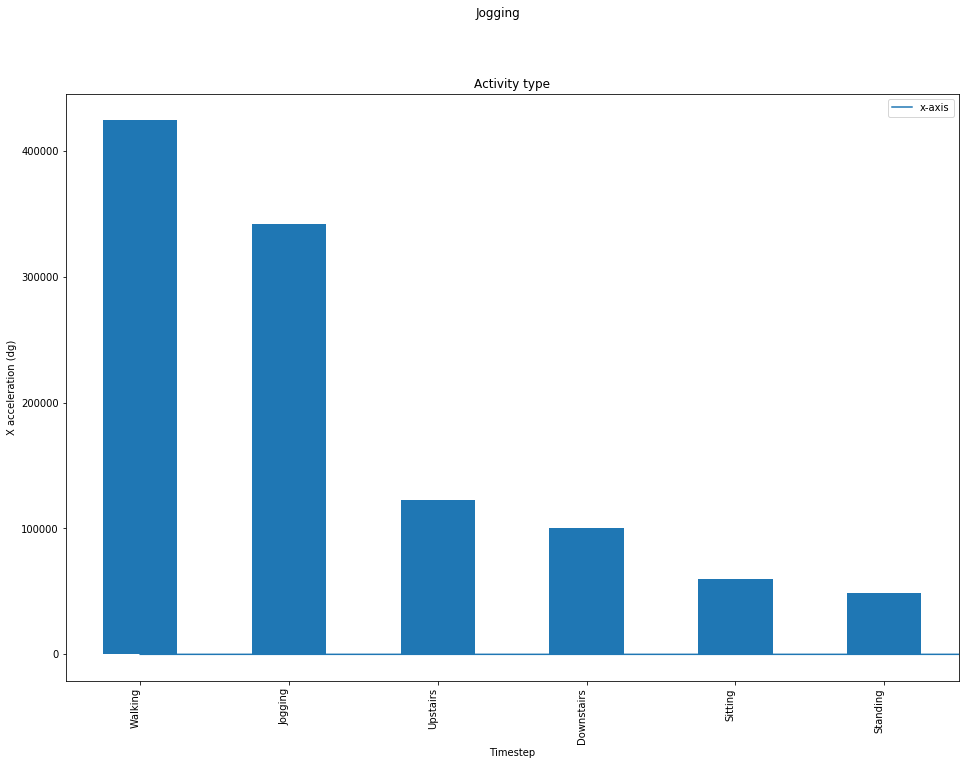

In [6]:
data[data['activity'] == 'Jogging'][['x-axis']][:50].plot(subplots=True, figsize=(16, 12), title='Jogging')
plt.xlabel('Timestep')
plt.ylabel('X acceleration (dg)')

# SHOW ACTIVITY GRAPH
activity_type = data['activity'].value_counts().plot(kind='bar', title='Activity type')
plt.show()

In [21]:
data.size

6589218

In [7]:
TIME_STEP = 60
SEGMENT_TIME_SIZE = 180
# DATA PREPROCESSING
data_convoluted = []
labels = []

    # Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
    x = data['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
    y = data['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
    z = data['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
    data_convoluted.append([x, y, z])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
    labels.append(label)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [8]:
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

In [9]:
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)

Convoluted data shape:  (18301, 180, 3)
Labels shape: (18301, 6)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_convoluted, labels, test_size=0.3)

In [11]:
print("X train size: ", len(X_train), X_train.shape)
print("X test size: ", len(X_test), X_test.shape)
print("y train size: ", len(y_train),y_test.shape)
print("y test size: ", len(y_test), y_test.shape)

X train size:  12810 (12810, 180, 3)
X test size:  5491 (5491, 180, 3)
y train size:  12810 (5491, 6)
y test size:  5491 (5491, 6)


In [25]:
print(X_train.size)
print(X_test.size)
print(len(X_train))

6917400
2965140
12810


In [12]:
def buildModelDense():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Dense(256, activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(128, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelGru():
    inp = layers.Input(shape=(180,3,))
    mod = layers.GRU(256, activation="tanh", return_sequences=True)(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.GRU(256, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNGRU():
    inp = layers.Input(shape=(180,3))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.GRU(64, activation="tanh", return_sequences=True)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNN():
    inp = layers.Input(shape=(180,3))
    mod = layers.Conv1D(64, 3, activation="relu")(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Conv1D(64, 3, activation="relu")(mod)
    mod = layers.MaxPooling1D(2)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(32, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelCNNLSTM():
    inp = layers.Input(shape=(180,3))
    mod = layers.TimeDistributed(layers.Conv1D(64, 3, activation="relu"))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.TimeDistributed(layers.Flatten())(mod)
    mod = layers.LSTM(64, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
#     mod = layers.Flatten()(mod)
    
    mod = layers.Dense(64, activation="relu")(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildModelLstm():
    inp = layers.Input(shape=(180,3))
    mod = layers.LSTM(64, activation="tanh", return_sequences=True)(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.LSTM(64, activation="tanh", return_sequences=False)(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildLSTMBi1():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi2():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
    mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi3():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
#     mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=False, recurrent_dropout=0.2))(mod)
#     mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    # gradient clipping and default opt is adam
#     opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildLSTMBi3_2():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    # gradient clipping and default opt is adam
#     opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model

def buildLSTMBi4():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.BatchNormalization()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi5():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model
def buildLSTMBi6():
    inp = layers.Input(shape=(180,3,))
    mod = layers.Bidirectional(LSTM(64, activation="tanh", return_sequences=True, recurrent_dropout=0.2))(inp)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Bidirectional(LSTM(64, activation="relu", return_sequences=False, recurrent_dropout=0.2))(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(512, activation="relu")(mod)
#     mod = layers.Flatten()(mod)
    mod = layers.Dropout(0.2)(mod)
    mod = layers.Dense(256, activation="relu")(mod)
    out = layers.Dense(6, activation="softmax")(mod)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
    return model


In [13]:
Epoch = 50
batch = 128
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.001)

In [16]:
# model_1 = buildModelDense()
model_2 = buildModelGru()
# model_3 = buildModelCNNGRU()
model_4 = buildModelCNN()
# model_5 = buildModelCNNLSTM()
model_6 = buildModelLstm()
model_91 = buildLSTMBi1()
model_92 = buildLSTMBi2()
model_93 = buildLSTMBi3()
model_932 = buildLSTMBi3_2()
model_94 = buildLSTMBi4()
model_95 = buildLSTMBi5()
model_96 = buildLSTMBi6()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# history_1 = model_1.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_2 = model_2.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
# history_3 = model_3.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_4 = model_4.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
# history_5 = model_5.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_6 = model_6.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_91 = model_91.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_92 = model_92.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_93 = model_93.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_932 = model_932.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_94 = model_94.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_95 = model_95.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])
history_96 = model_96.fit(X_test,y_test,batch_size=batch,epochs=Epoch,verbose=1, callbacks = [early_stopping,reduce_lr])


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
5491/5491 [==============================] - 112s 20ms/step - loss: 0.9983 - acc: 0.6498


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/50
5491/5491 [==============================] - 108s 20ms/step - loss: 0.5492 - acc: 0.8042
Epoch 3/50
5491/5491 [==============================] - 107s 20ms/step - loss: 0.3934 - acc: 0.8519
Epoch 4/50
5491/5491 [==============================] - 109s 20ms/step - loss: 0.3137 - acc: 0.8858
Epoch 5/50
5491/5491 [==============================] - 110s 20ms/step - loss: 0.2242 - acc: 0.9193
Epoch 6/50
5491/5491 [==============================] - 110s 20ms/step - loss: 0.1725 - acc: 0.9372
Epoch 7/50
5491/5491 [==============================] - 108s 20ms/step - loss: 0.1266 - acc: 0.9537
Epoch 8/50
5491/5491 [==============================] - 109s 20ms/step - loss: 0.1298 - acc: 0.9530
Epoch 9/50
5491/5491 [==============================] - 111s 20ms/step - loss: 0.0928 - acc: 0.9670
Epoch 10/50
5491/5491 [==============================] - 110s 20ms/step - loss: 0.0819 - acc: 0.9687
Epoch 11/50
5491/5491 [==============================] - 110s 20ms/step - loss: 0.0656 - acc: 0.977

5491/5491 [==============================] - 6s 1ms/step - loss: 0.1093 - acc: 0.9618
Epoch 35/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.1148 - acc: 0.9623
Epoch 36/50
5491/5491 [==============================] - 7s 1ms/step - loss: 0.1121 - acc: 0.9619
Epoch 37/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0985 - acc: 0.9656
Epoch 38/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0911 - acc: 0.9710
Epoch 39/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0854 - acc: 0.9696
Epoch 40/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0974 - acc: 0.9658
Epoch 41/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0932 - acc: 0.9676
Epoch 42/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0763 - acc: 0.9761
Epoch 43/50
5491/5491 [==============================] - 6s 1ms/step - loss: 0.0790 - acc: 0.9721
Epoch 44/50
5491/5491 [=========

5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 17/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 18/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 19/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 20/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 21/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 22/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 23/50
5491/5491 [==============================] - 99s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 24/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Epoch 25/50
5491/5491 [==============================] - 98s 18ms/step - loss: 10.9841 - acc: 0.3185
Ep

5491/5491 [==============================] - 101s 18ms/step - loss: 0.0245 - acc: 0.9954
Epoch 48/50
5491/5491 [==============================] - 101s 18ms/step - loss: 0.0238 - acc: 0.9925
Epoch 49/50
5491/5491 [==============================] - 101s 18ms/step - loss: 0.0485 - acc: 0.9907
Epoch 50/50
5491/5491 [==============================] - 101s 18ms/step - loss: 0.0462 - acc: 0.9898
Epoch 1/50
5491/5491 [==============================] - 76s 14ms/step - loss: nan - acc: 0.0925
Epoch 2/50
5491/5491 [==============================] - 67s 12ms/step - loss: nan - acc: 0.0938
Epoch 3/50
5491/5491 [==============================] - 67s 12ms/step - loss: nan - acc: 0.0938
Epoch 4/50
5491/5491 [==============================] - 67s 12ms/step - loss: nan - acc: 0.0938
Epoch 5/50
5491/5491 [==============================] - 67s 12ms/step - loss: nan - acc: 0.0938
Epoch 6/50
5491/5491 [==============================] - 67s 12ms/step - loss: nan - acc: 0.0938
Epoch 7/50
5491/5491 [==========

5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 32/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 33/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 34/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 35/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 36/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 37/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 38/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 39/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 40/50
5491/5491 [==============================] - 71s 13ms/step - loss: nan - acc: 0.0938
Epoch 41/50
5491/5491 [===================

5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 15/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 16/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 17/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 18/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 19/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 20/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 21/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 22/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 23/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 24/50
5491/5491 [===================

5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 49/50
5491/5491 [==============================] - 68s 12ms/step - loss: nan - acc: 0.0938
Epoch 50/50
5491/5491 [==============================] - 69s 13ms/step - loss: nan - acc: 0.0938


In [18]:
%run eval_score.ipynb 

In [19]:
# y_pred1 = model_1.predict(X_test)
# y_pred1 = y_pred1.argmax(axis=1)
y_pred2 = model_2.predict(X_test)
y_pred2 = y_pred2.argmax(axis=1)
# y_pred3 = model_3.predict(X_test)
# y_pred3 = y_pred3.argmax(axis=1)
y_pred4 = model_4.predict(X_test)
y_pred4 = y_pred4.argmax(axis=1)
# y_pred5 = model_5.predict(X_test)
# y_pred5 = y_pred5.argmax(axis=1)
y_pred6 = model_6.predict(X_test)
y_pred6 = y_pred6.argmax(axis=1)
y_pred91 = model_91.predict(X_test)
y_pred91 = y_pred91.argmax(axis=1)
y_pred92 = model_92.predict(X_test)
y_pred92 = y_pred92.argmax(axis=1)
y_pred93 = model_93.predict(X_test)
y_pred93 = y_pred93.argmax(axis=1)
y_pred932 = model_932.predict(X_test)
y_pred932 = y_pred932.argmax(axis=1)
y_pred94 = model_94.predict(X_test)
y_pred94 = y_pred94.argmax(axis=1)
y_pred95 = model_95.predict(X_test)
y_pred95 = y_pred95.argmax(axis=1)
y_pred96 = model_96.predict(X_test)
y_pred96 = y_pred96.argmax(axis=1)

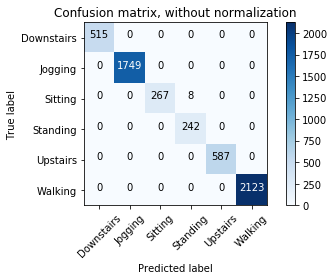

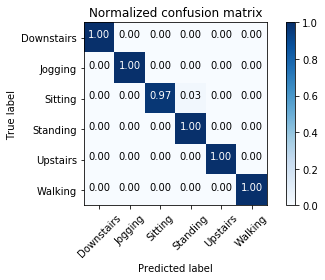

              precision    recall  f1-score   support

  Downstairs       1.00      1.00      1.00       515
     Jogging       1.00      1.00      1.00      1749
     Sitting       1.00      0.97      0.99       275
    Standing       0.97      1.00      0.98       242
    Upstairs       1.00      1.00      1.00       587
     Walking       1.00      1.00      1.00      2123

    accuracy                           1.00      5491
   macro avg       0.99      1.00      0.99      5491
weighted avg       1.00      1.00      1.00      5491



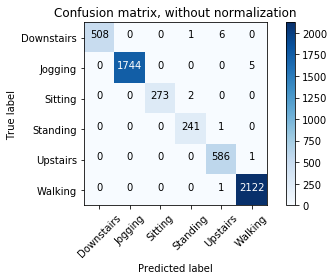

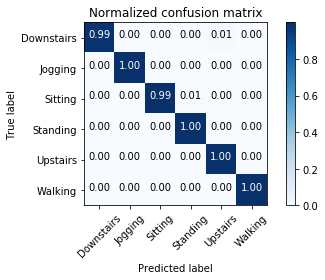

              precision    recall  f1-score   support

  Downstairs       1.00      0.99      0.99       515
     Jogging       1.00      1.00      1.00      1749
     Sitting       1.00      0.99      1.00       275
    Standing       0.99      1.00      0.99       242
    Upstairs       0.99      1.00      0.99       587
     Walking       1.00      1.00      1.00      2123

    accuracy                           1.00      5491
   macro avg       1.00      0.99      1.00      5491
weighted avg       1.00      1.00      1.00      5491



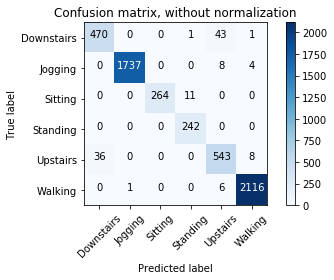

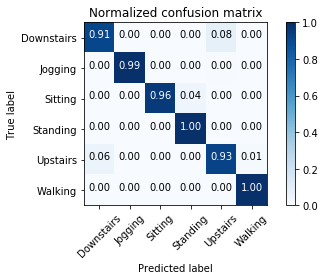

              precision    recall  f1-score   support

  Downstairs       0.93      0.91      0.92       515
     Jogging       1.00      0.99      1.00      1749
     Sitting       1.00      0.96      0.98       275
    Standing       0.95      1.00      0.98       242
    Upstairs       0.91      0.93      0.91       587
     Walking       0.99      1.00      1.00      2123

    accuracy                           0.98      5491
   macro avg       0.96      0.96      0.96      5491
weighted avg       0.98      0.98      0.98      5491



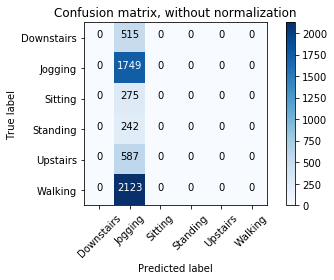

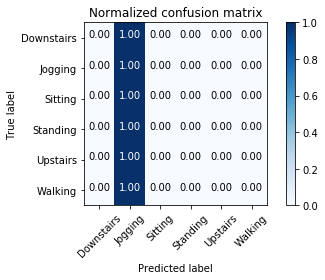

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  Downstairs       0.00      0.00      0.00       515
     Jogging       0.32      1.00      0.48      1749
     Sitting       0.00      0.00      0.00       275
    Standing       0.00      0.00      0.00       242
    Upstairs       0.00      0.00      0.00       587
     Walking       0.00      0.00      0.00      2123

    accuracy                           0.32      5491
   macro avg       0.05      0.17      0.08      5491
weighted avg       0.10      0.32      0.15      5491



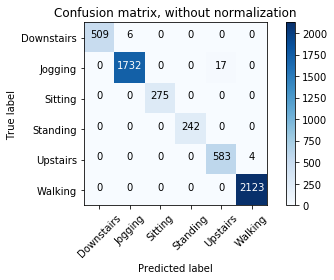

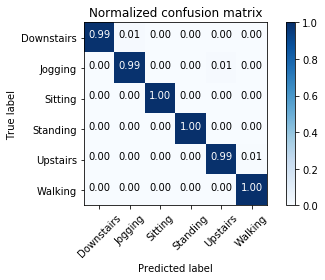

              precision    recall  f1-score   support

  Downstairs       1.00      0.99      0.99       515
     Jogging       1.00      0.99      0.99      1749
     Sitting       1.00      1.00      1.00       275
    Standing       1.00      1.00      1.00       242
    Upstairs       0.97      0.99      0.98       587
     Walking       1.00      1.00      1.00      2123

    accuracy                           1.00      5491
   macro avg       0.99      1.00      0.99      5491
weighted avg       1.00      1.00      1.00      5491



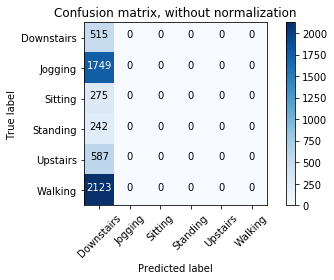

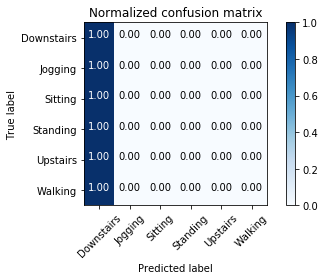

              precision    recall  f1-score   support

  Downstairs       0.09      1.00      0.17       515
     Jogging       0.00      0.00      0.00      1749
     Sitting       0.00      0.00      0.00       275
    Standing       0.00      0.00      0.00       242
    Upstairs       0.00      0.00      0.00       587
     Walking       0.00      0.00      0.00      2123

    accuracy                           0.09      5491
   macro avg       0.02      0.17      0.03      5491
weighted avg       0.01      0.09      0.02      5491



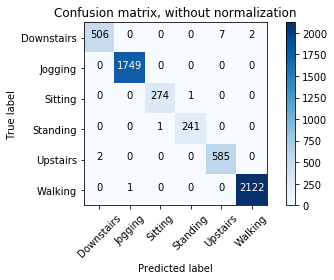

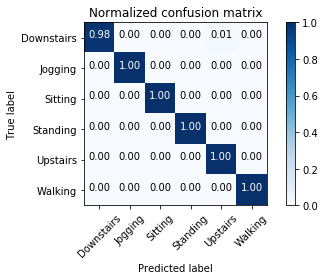

              precision    recall  f1-score   support

  Downstairs       1.00      0.98      0.99       515
     Jogging       1.00      1.00      1.00      1749
     Sitting       1.00      1.00      1.00       275
    Standing       1.00      1.00      1.00       242
    Upstairs       0.99      1.00      0.99       587
     Walking       1.00      1.00      1.00      2123

    accuracy                           1.00      5491
   macro avg       1.00      1.00      1.00      5491
weighted avg       1.00      1.00      1.00      5491



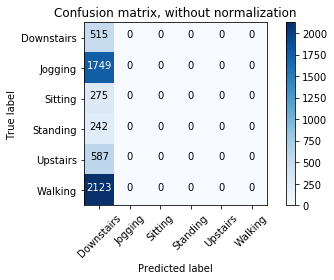

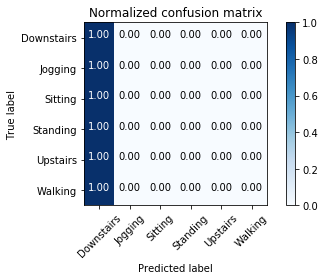

              precision    recall  f1-score   support

  Downstairs       0.09      1.00      0.17       515
     Jogging       0.00      0.00      0.00      1749
     Sitting       0.00      0.00      0.00       275
    Standing       0.00      0.00      0.00       242
    Upstairs       0.00      0.00      0.00       587
     Walking       0.00      0.00      0.00      2123

    accuracy                           0.09      5491
   macro avg       0.02      0.17      0.03      5491
weighted avg       0.01      0.09      0.02      5491



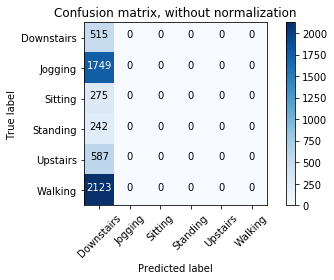

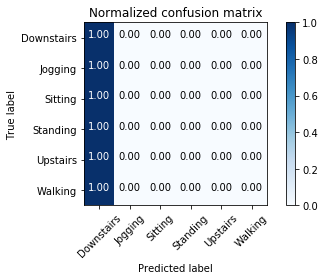

              precision    recall  f1-score   support

  Downstairs       0.09      1.00      0.17       515
     Jogging       0.00      0.00      0.00      1749
     Sitting       0.00      0.00      0.00       275
    Standing       0.00      0.00      0.00       242
    Upstairs       0.00      0.00      0.00       587
     Walking       0.00      0.00      0.00      2123

    accuracy                           0.09      5491
   macro avg       0.02      0.17      0.03      5491
weighted avg       0.01      0.09      0.02      5491



In [20]:
# show_conf_matrix(y_test.argmax(axis=1), y_pred1, LABELS)
# show_clf_report(y_test.argmax(axis=1), y_pred1, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred2, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred2, LABELS)
# show_conf_matrix(y_test.argmax(axis=1), y_pred3, LABELS)
# show_clf_report(y_test.argmax(axis=1), y_pred3, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred4, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred4, LABELS)
# show_conf_matrix(y_test.argmax(axis=1), y_pred5, LABELS)
# show_clf_report(y_test.argmax(axis=1), y_pred5, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred6, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred6, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred91, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred91, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred92, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred92, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred932, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred932, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred94, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred94, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred95, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred95, LABELS)
show_conf_matrix(y_test.argmax(axis=1), y_pred96, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred96, LABELS)

In [18]:
y_pred3 = model_93.predict(X_test)
y_pred3 = y_pred3.argmax(axis=1)

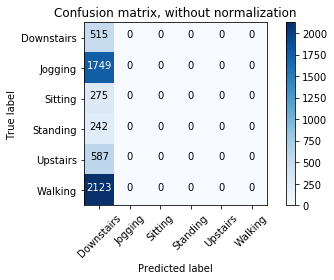

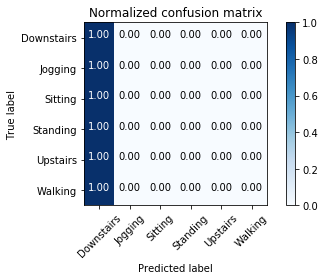

              precision    recall  f1-score   support

  Downstairs       0.09      1.00      0.17       515
     Jogging       0.00      0.00      0.00      1749
     Sitting       0.00      0.00      0.00       275
    Standing       0.00      0.00      0.00       242
    Upstairs       0.00      0.00      0.00       587
     Walking       0.00      0.00      0.00      2123

    accuracy                           0.09      5491
   macro avg       0.02      0.17      0.03      5491
weighted avg       0.01      0.09      0.02      5491



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
show_conf_matrix(y_test.argmax(axis=1), y_pred3, LABELS)
show_clf_report(y_test.argmax(axis=1), y_pred3, LABELS)